# Submission
Submitted by Roy Asher, ID 200844009

Kaggle profile: https://www.kaggle.com/royabr121

# Introduction

This notebook is my attempt at the "House Prices - Advanced Regression Techniques" competition. The goal of this competiton is to use a data set, consisting of 1459 housing sales with 79(!) features in order to predict the sale price for any newer sales using regression techniques. As part of the Machine Learning course I am currenlty going through I was instructed to use both cross validation and automatic feature selection
in order to submit my own predications. 

# Imports and Functions

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut

from pandas_profiling import ProfileReport

import phik
from phik import resources, report
from tqdm.auto import tqdm
import plotly.express as px
from math import sqrt

import plotly.graph_objects as go
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold

In [ ]:
#perform cross validation using K-Fold and present results with RMSE graphs
def display_cv_kfold_rmse(X, t, model, max_k=None):

    mean_scores_losses_df = pd.DataFrame(columns=['K', 'Split', 'Score(R2)', 'Loss(RMSE)'])
    
    for k in range(2,max_k + 1):
        
        scores_losses_df = pd.DataFrame(columns=['Fold ID', 'Split', 'Score(R2)', 'Loss(RMSE)'])
        cv = KFold(n_splits=k, shuffle=True, random_state=1)
    
        for i, (train_ids, val_ids) in enumerate(cv.split(X)):

            X_train = X.loc[train_ids]
            t_train = t.loc[train_ids]
            X_val = X.loc[val_ids]
            t_val = t.loc[val_ids]

            model.fit(X_train, t_train)

            y_train = model.predict(X_train)
            y_val = model.predict(X_val)
            
            scores_losses_df.loc[len(scores_losses_df)] = [i, 'Train', model.score(X_train, t_train), sqrt(mean_squared_error(t_train, y_train))]
            scores_losses_df.loc[len(scores_losses_df)] = [i, 'Validation', model.score(X_val, t_val), sqrt(mean_squared_error(t_val, y_val))]
        
        train_scores_losses_df = scores_losses_df[scores_losses_df['Split']=='Train']
        val_scores_losses_df = scores_losses_df[scores_losses_df['Split']=='Validation']
        
        mean_train_score = train_scores_losses_df['Score(R2)'].mean()
        mean_train_loss = train_scores_losses_df['Loss(RMSE)'].mean()
        mean_val_score = val_scores_losses_df['Score(R2)'].mean()
        mean_val_loss = val_scores_losses_df['Loss(RMSE)'].mean()

        mean_scores_losses_df.loc[len(mean_scores_losses_df)] = [k, 'Train', mean_train_score, mean_train_loss]
        mean_scores_losses_df.loc[len(mean_scores_losses_df)] = [k, 'Validation', mean_val_score, mean_val_loss]

    fig = px.line(mean_scores_losses_df, x='K', y='Loss(RMSE)', color='Split')
    fig.show()
    
# perform backwards features selection - display the selected features and return the selector
def backward_features_selection(model, X, t, k): 
    
    selector = RFECV(model, cv=RepeatedKFold(n_splits=k, n_repeats=10, random_state=1)).fit(X, t)
    display(X_encoded.loc[:, selector.support_].columns.values.tolist())

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[i for i in range(1, len(selector.grid_scores_) + 1)], y=selector.grid_scores_))
    fig.update_xaxes(title_text="Number of Features Selected")
    fig.update_yaxes(title_text="Cross Validation Score (nb of correct classifications)")
    fig.show()

    return selector

# Data Exploration

In [ ]:
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train_df

In [ ]:
print(train_df.info())

In [ ]:
print(test_df.info())

Produce a Pandas Report to HTML file, the reason being the training data so large that it cannot be viewed on the editor. **Note: producting the report takes a while, so uncomment only if you wish to view the report.**

In [ ]:
# Get Pandas Report for Data Exploration:
#profile = ProfileReport(train_df, title="House Pricing Report")
#profile.to_file("house_train_df_profile.html")

View the missing data in both training and test sets:

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(data=train_df.isnull())

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(data=test_df.isnull())

From studying the competition data and the Pandas Profile Report I found that in some features NaN is an actual category, and not missing data. we will deal with this problem in pre-processing.

In [ ]:
# actually missing data:
na_means_no_data_columns=['LotFrontage','GarageYrBlt','MasVnrArea','Electrical']

# NaN simply means the absence of a certain feature(e.g. a cell with NaN for 'Fence' means there is no fence):
na_means_absence_columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageFinish','GarageType', 'GarageCond','GarageQual','BsmtFinType1','BsmtFinType2','BsmtCond','BsmtExposure', 'BsmtQual','MasVnrType']

Let's produce heatmaps for the different features using the Phi-K correlation coefficient, just like in the Profile Report:

In [ ]:
columns = train_df.columns.values.tolist()
first_half = columns[:42]
first_half.append(columns[80])
second_half = columns[42:]

# first heatmap
plt.figure(figsize=(30,30))
cor = train_df[first_half].phik_matrix()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.ioff()

In [ ]:
# second heatmap
plt.figure(figsize=(30,30))
cor = train_df[second_half].phik_matrix()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.ioff()

Since there are so many features in this data set, we will explore the 6 features that correlate most strongly with 'SalePrice':

* OverallQual - 0.82
* GrLivArea - 0.89
* 2ndFlrSF - 0.86
* MasVnrType - 0.93
* MasVnrArea - 0.93
* LotFrontage - 0.83

In [ ]:
# scatterplot
sns.set()
cols = ['OverallQual', 'GrLivArea', '2ndFlrSF', 'MasVnrType', 'MasVnrArea','LotFrontage','SalePrice']
sns.pairplot(train_df[cols], height=5)
plt.show()
plt.ioff()
#print(train_df[cols])

In [ ]:
plt.figure(figsize=(20,10))
px.scatter(train_df, x='OverallQual', y='SalePrice', title='SalePrice vs OverallQual', render_mode='auto')

As we can see 'OverallQual' and 'SalePrice' have a very linear relationship. This is not surprising, since the overall quality of every product(houses included) tends to dictate the price.

In [ ]:
plt.figure(figsize=(20,10))
px.scatter(train_df, x='GrLivArea', y='SalePrice', title='SalePrice vs GrLivArea', render_mode='auto')

 The greater the 'GrLivArea'(above ground living area) the greater the house sale price. This is not surprising, as more living area means a bigger house which in turn costs more. However there are two outliers that should be desposed of:

In [ ]:
indices = train_df[(train_df['GrLivArea'] == 4676) | (train_df['GrLivArea'] == 5642)].index
train_df.drop(indices, inplace=True)

In [ ]:
plt.figure(figsize=(20,10))
px.scatter(train_df, x='2ndFlrSF', y='SalePrice', title='SalePrice vs 2ndFlrSF', render_mode='auto')

As we can see, a square foot of a second floor most definitly adds to the overall price of the house - it is a linear relationship. However, as we can see from the houses in which there is no second floor that it is quite possible to have a higher price tag than a house with 2 floors. It is a factor, but not the most critical one.

In [ ]:
fig = sns.boxplot(x='MasVnrType', y="SalePrice", data=train_df)

In [ ]:
sns.relplot(x="MasVnrArea", y="SalePrice", hue="MasVnrType", size="MasVnrArea",
            sizes=(100, 200), alpha=.5, palette="muted",
            height=10, data=train_df)

As can be seen from the two graphs above the area of masonry built with the house increses the price. The type itself also infulences the price, with stone masonry being the most expensive and common bricks or not masonry being the cheapest. 

In [ ]:
plt.figure(figsize=(20,10))
px.scatter(train_df, x='LotFrontage', y='SalePrice', title='SalePrice vs LotFrontage', render_mode='auto')

We will despose of the one outliers we have:

In [ ]:
indices = train_df[train_df['LotFrontage'] == 313].index
train_df.drop(indices, inplace=True)

# Pre-Processing

**training data:**

In [ ]:
# now we view the missing data without the columns where NaN or None simply means absence of a certain feature for those columns: 
missing_data_columns=['GarageYrBlt','MasVnrArea','Electrical']
na_is_absence_columns=['LotFrontage','PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageFinish','GarageType','GarageCond','GarageQual','BsmtFinType1','BsmtFinType2','BsmtCond','BsmtExposure','BsmtQual','MasVnrType']

missing = train_df.drop(na_is_absence_columns, axis=1).isnull().sum().sort_values(ascending=False)
percent = round(missing / len(train_df) * 100, 2)
pd.concat([missing,percent],axis = 1,keys = ['Missing Value Totals','Percentage'])

In the case of the 'LotFrontage' and 'Electrical' columns missing data we will simply drop the rows, the reason being the competition allows for discarding rows in the training data (but not the test data). This way we can influence the results minimally instead of making educated guesses which might result in less accurate models.

In [ ]:
# we will drop the 'LotFrontage' and 'Electrical' cells with NaN values:
train_df = train_df[train_df['Electrical'].notnull()]
train_df.reset_index(inplace=True)

In [ ]:
##fix missing 'GarageYrBlt' and 'MasVnrArea' data
GarageType_vs_GarageYrBlt = (train_df.loc[train_df['GarageType'].isnull()])['Id'].equals((train_df.loc[train_df['GarageYrBlt'].isnull()])['Id'])
MasVnrType_vs_MasVnrArea = (train_df.loc[train_df['MasVnrType'].isnull()])['Id'].equals((train_df.loc[train_df['MasVnrArea'].isnull()])['Id'])

print("'GarageType' nulls cause the 'GarageYrBlt' =", GarageType_vs_GarageYrBlt)
print("'MasVnrType' nulls cause the 'MasVnrArea' =", MasVnrType_vs_MasVnrArea)

In [ ]:
# now all remaining nulls, both numbers and categorical, will be turned to 0s and 'N/A' strings respectivly 
train_df_number_columns = train_df.select_dtypes(exclude='object')
train_df_object_columns = train_df.select_dtypes('object')
train_df_number_columns.replace({np.nan : 0}, inplace=True)
train_df_object_columns.replace({np.nan : 'N/A'}, inplace=True)
train_df_modified = pd.concat([train_df_number_columns, train_df_object_columns], axis=1).drop(columns='index')

missing = train_df_modified.isnull().sum().sort_values(ascending=False)
percent = round(missing / len(train_df) * 100, 2)
pd.concat([missing,percent],axis = 1,keys = ['Missing Value Totals','Percentage'])

**test data:**

In [ ]:
missing = test_df.drop(na_is_absence_columns, axis=1).isnull().sum().sort_values(ascending=False)
percent = round(missing / len(test_df) * 100, 2)
pd.concat([missing,percent],axis = 1,keys = ['Missing Value Totals','Percentage'])
missing.head(20)

We are not allowed to discard any rows in the test data, so we will need to compensate for the absence of the data as best we can. The following missing data compensation has been done by studying the characteristics of the rows with the missing data:

In [ ]:
# due to absent basement:
test_df.loc[test_df['BsmtFinSF1'].isnull(), ['BsmtFinSF1']]=0
test_df.loc[test_df['BsmtFinSF2'].isnull(), ['BsmtFinSF2']]=0
test_df.loc[test_df['BsmtUnfSF'].isnull(), ['BsmtUnfSF']]=0 
test_df.loc[test_df['TotalBsmtSF'].isnull(), ['TotalBsmtSF']]=0

# the sale type is unknown - will be listed as the most common type:
test_df.loc[test_df['SaleType'].isnull(), ['SaleType']]='Oth'
test_df.loc[test_df['Exterior1st'].isnull(), ['Exterior1st']]=test_df['Exterior1st'].value_counts().idxmax()
test_df.loc[test_df['Exterior2nd'].isnull(), ['Exterior2nd']]=test_df['Exterior2nd'].value_counts().idxmax()

# the dimensions of the garage are unknown - we will use mean values:
test_df.loc[test_df['GarageCars'].isnull(), ['GarageCars']]=test_df['GarageCars'].mean()
test_df.loc[test_df['GarageArea'].isnull(), ['GarageArea']]=test_df['GarageArea'].mean()

#test_df['GarageCars'].mean()
#test_df.loc[test_df['GarageCars'].isnull()]

# the kitchen quality is unknown - will be listed as the most common type:
test_df.loc[test_df['KitchenQual'].isnull(), ['KitchenQual']]=test_df['KitchenQual'].value_counts().idxmax()

# there is not basement - so there would not be in baths in basement:
test_df.loc[test_df['BsmtFullBath'].isnull(), ['BsmtFullBath']]=0
test_df.loc[test_df['BsmtHalfBath'].isnull(), ['BsmtHalfBath']]=0

# no data about house functionality - we will assume most commom type:
test_df.loc[test_df['Functional'].isnull(), ['Functional']]=test_df['Functional'].value_counts().idxmax()

# no data about house utilities - we will assume most commom type:
test_df.loc[test_df['Utilities'].isnull(), ['Utilities']]=test_df['Utilities'].value_counts().idxmax()

# no data about general zoning classification of the sale - we will assume most commom type:
test_df.loc[test_df['MSZoning'].isnull(), ['MSZoning']]=test_df['MSZoning'].value_counts().idxmax()

# due to the absence of any masonry: 
test_df.loc[test_df['MasVnrArea'].isnull(), ['MasVnrArea']]=0

# due to the absence of any masonry: 
test_df.loc[test_df['GarageYrBlt'].isnull(), ['GarageYrBlt']]=0

# some missing data and some absences of garage - in both cases we will assume the mean value in order to compensate since this will hurt prediction accuracy the least:
test_df.loc[test_df['GarageYrBlt'].isnull(), ['GarageYrBlt']]=test_df['GarageYrBlt'].value_counts().idxmax()

# several columns in the test data have a mismatched dtype with their counterparts in the training data. We will now fix this:
test_df = test_df.astype({"BsmtFinSF1": int, "BsmtFinSF2": int, "BsmtUnfSF": int, "TotalBsmtSF": int, "BsmtFullBath": int, "BsmtHalfBath": int, "GarageCars": int, "GarageArea": int})

In [ ]:
# now all remaining nulls, both numbers and object, will be turned to 0s and 'N/A' strings respectivly 
test_df_number_columns = test_df.select_dtypes(exclude='object')
test_df_object_columns = test_df.select_dtypes('object')
test_df_number_columns.replace({np.nan : 0}, inplace=True)
test_df_object_columns.replace({np.nan : 'N/A'}, inplace=True)

# unify the columns
test_df_modified = pd.concat([test_df_number_columns, test_df_object_columns], axis=1)

In [ ]:
print(test_df.info())

In [ ]:
missing = test_df_modified.isnull().sum().sort_values(ascending=False)
percent = round(missing / len(test_df_modified) * 100, 2)
pd.concat([missing,percent], axis = 1, keys = ['Missing Value Totals','Percentage'])
missing.head(20)

Not that both training and test data sets have identical columns and no missing data, we can begin creating regression models.

# Testing and Models

The following models represent the result of much trial and error on my behalf. Each one is the best result I have achieved, since including every variation I tried is not possible. I used both Lasso and SGDRegressor(). For cross validation I chose to use the K-Fold method, given the size of the data sets (its is considerably faster than LPO) as well the fact that it was considred accurate enough in many scenarios. **Note: that this sections takes a long time to run(about 10 minutes)**.

In [ ]:
# divide the data to features and target
t = train_df_modified['SalePrice'].copy()
X = train_df_modified.copy().drop(['SalePrice'], axis=1)

# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'boolean']).columns
all_cols = np.array(X.columns)

In [ ]:
ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, SGDRegressor(random_state=1))

display_cv_kfold_rmse(X, t, model_pipe, 20)

It appears the best results for the CV can be found when k=4 and k=6. We will try them both.

In [ ]:
ct_enc_std = ColumnTransformer([("encoding", OrdinalEncoder(), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
model = SGDRegressor(random_state=1)

In [ ]:
selector_k4 = backward_features_selection(model, X_encoded, t, 4)

In [ ]:
X = train_df_modified[X_encoded.loc[:, selector_k4.support_].columns.values.tolist()]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'boolean']).columns
all_cols = np.array(X.columns)

ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, SGDRegressor(random_state=1))

display_cv_kfold_rmse(X, t, model_pipe, 20)

In [ ]:
selector_k6 = backward_features_selection(model, X_encoded, t, 6)

In [ ]:
X = train_df_modified[X_encoded.loc[:, selector_k6.support_].columns.values.tolist()]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'boolean']).columns
all_cols = np.array(X.columns)

ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, SGDRegressor(random_state=1))

display_cv_kfold_rmse(X, t, model_pipe, 20)

As we can see, both feature selections where k=4 and k=6 had much worse results than the full features list - almost double RMSE loss. This is troubling, so we will try a different model: Lasso().

In [ ]:
# divide the data to features and target
t = train_df_modified['SalePrice'].copy()
X = train_df_modified.copy().drop(['SalePrice'], axis=1)

# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'boolean']).columns
all_cols = np.array(X.columns)

In [ ]:
ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, Lasso(normalize=True, max_iter=5000, selection='random'))

display_cv_kfold_rmse(X, t, model_pipe, 20)

K=12 appears to be ideal for this model and data.

In [ ]:
ct_enc_std = ColumnTransformer([("encoding", OrdinalEncoder(), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
model = Lasso(normalize=True, max_iter=5000, selection='random')

In [ ]:
selector = backward_features_selection(model, X_encoded, t, 12)

In [ ]:
X = train_df_modified[X_encoded.loc[:, selector.support_].columns.values.tolist()]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'boolean']).columns
all_cols = np.array(X.columns)

ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, model)

display_cv_kfold_rmse(X, t, model_pipe, 20)

After the RFE feature selection I decided to also attempt to use manual selection. The following columns are the ones I have determined to have adverse effect on the regression models, based on the two heatmaps above:
* Utilities
* Street
* LandSlope
* LandContour
* Heating
* Condition2
* BsmtFinType2
* BsmtFinSF2
* YrSold
* MoSold
* MiscVal
* MiscFeature
* KitchenAbvGr
* Functional
* Fence
* EnclosedPorch
* BsmtHalfBath
* 3SsnPorch
* Id
* SalePrice

In [ ]:
X_columns = train_df_modified.drop(columns=['Utilities', 'Street', 'LandSlope', 'LandContour', 'Heating', 'Condition2', 'BsmtFinType2', 'BsmtFinSF2', 
                      'YrSold', 'MoSold', 'MiscVal', 'MiscFeature', 'KitchenAbvGr', 'Functional', 'Fence', 'EnclosedPorch', 
                      'BsmtHalfBath', '3SsnPorch', 'Id', 'SalePrice']).columns.values.tolist()
y_column = 'SalePrice'

# Submission

In [ ]:
X_train = train_df_modified[X_columns]
t_train = train_df_modified[y_column]

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'boolean']).columns

ct = ColumnTransformer([("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols), ("standard", StandardScaler(), numerical_cols)])
SGD_cls = pipeline.make_pipeline(ct, Lasso(normalize=True, max_iter=5000, selection='random')).fit(X_train, t_train)
X_test = test_df_modified[X_columns]
Id = test_df_modified['Id']
predictions = SGD_cls.predict(X_test)

my_submission = pd.DataFrame({'Id': Id, 'SalePrice': predictions})
my_submission.to_csv('submission2.csv', index = False)

# Results and Conclusions

In this assignment, I attempted to predict the results of the testing data using data exploration, regression model configuration, cross validation and automatic feature selection. Even though I attempted to use feature selection with the Backwards Feature Selection I did not achieve the results I expected. The final result was that either using all of the features provided or simply doing manual feature selection provided better results. My conclusion in this regards is that I currently lack the experiance and need to refine my use of feature selection. As far as cross validation is concerned, I found it to be better than the previous use of breaking the data to train-validation splits. It proved to be an excellent tool, and I would like to expand my knowledge and experience using it in the future. The most succesful regression models I used were based on Lasso, with SGDRegressor coming a close second and LinearRegression() models being so bad I did not even include them in this notebook. Aside from this, I feel I could have achieved better had more time.

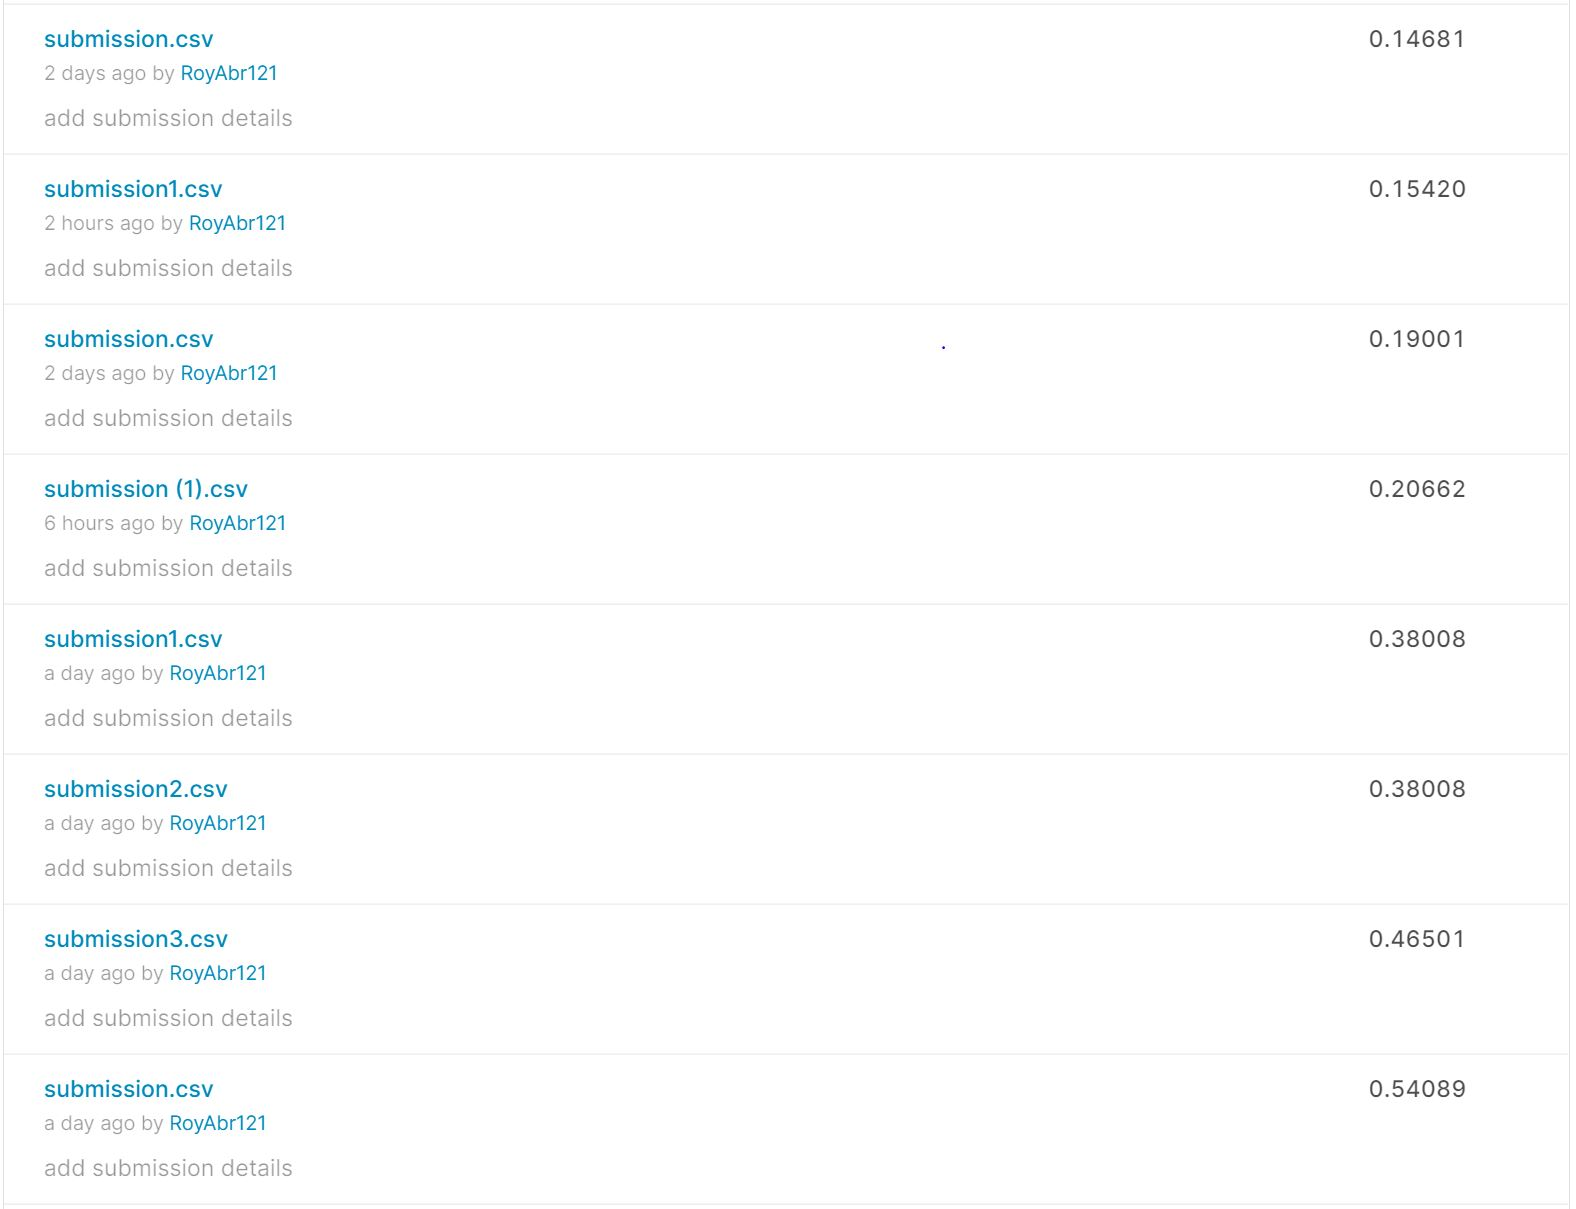